# Proyek Klasifikasi Gambar: Kucing dan Anjing
- **Nama:** Zev Hadid Santoso
- **Email:** zevhadid@gmail.com
- **ID Dicoding:** MS108D5Y0533

## Import Semua Packages/Library yang Digunakan

In [1]:
# Install tensorflowjs untuk menyimpan model sebagai tfjs
!pip install tensorflowjs

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from sklearn.model_selection import train_test_split
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import io
from google.colab import files

## Data Preparation

### Data Loading

In [4]:
# Upload kaggle.json
files.upload()

# memindahkan file kaggle.json ke folder .kaggle dan mengatur izin akses file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari kaggle
!pip install -q kaggle
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0



In [12]:
# Extract file cat-dog-images-for-classification.zip menjadi folder data
with zipfile.ZipFile("cat-dog-images-for-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Load dataset data/cat_dog.csv ke dataframe
df = pd.read_csv("data/cat_dog.csv")

# Modifikasi kolom "image" pada dataframe supaya url gambarnya lengkap
df['image'] = "data/cat_dog/" + df['image']

# Konversi tipe data pada kolom "labels" menjadi string
df['labels'] = df['labels'].astype(str)

# Memeriksa file yang hilang
df = df[df['image'].apply(os.path.exists)]
print(f"Dataset: {len(df)} images ({df['labels'].value_counts().to_dict()})")

Dataset: 25000 images ({'1': 12500, '0': 12500})


### Data Preprocessing

#### Split Dataset

In [13]:
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

def create_generator(df, augment=False):
    return ImageDataGenerator(
        rescale=1./255,
        **({'rotation_range':20, 'horizontal_flip':True} if augment else {})
    ).flow_from_dataframe(
        dataframe=df,
        x_col='image',
        y_col='labels',
        target_size=(150,150),
        batch_size=32,
        class_mode='binary',
        shuffle=augment
    )

train_gen = create_generator(train_df, augment=True)
val_gen = create_generator(val_df)
test_gen = create_generator(test_df)

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Modelling

In [14]:
# Membuat model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Training model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 126s 254ms/step - accuracy: 0.5468 - loss: 0.7055 - val_accuracy: 0.6684 - val_loss: 0.5990
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 245ms/step - accuracy: 0.6916 - loss: 0.5838 - val_accuracy: 0.7772 - val_loss: 0.4831
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 242ms/step - accuracy: 0.7462 - loss: 0.5236 - val_accuracy: 0.7724 - val_loss: 0.4746
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 246ms/step - accuracy: 0.7627 - loss: 0.4919 - val_accuracy: 0.8008 - val_loss: 0.4301
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step - accuracy: 0.7949 - loss: 0.4423 - val_accuracy: 0.8214 - val_loss: 0.3952
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 243ms/step - accuracy: 0.8088 - loss: 0.4217 - val_accuracy: 0.8396 - val_loss: 0.3785
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step - accuracy: 0.8216 - loss: 0.3992 - val_accuracy: 0.8406 - val_loss: 0.3577
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 238ms/step - accuracy: 0.8302 -

## Evaluasi dan Visualisasi

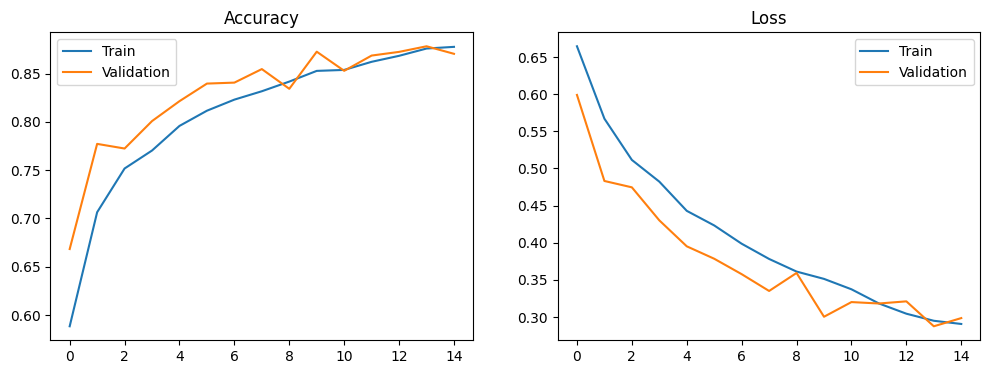

In [15]:
# Visualisasi model
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [20]:
# Evalusasi model

train_loss, train_acc = model.evaluate(train_gen)
print(f"Akurasi Training: {train_acc:.2%}")

test_loss, test_acc = model.evaluate(test_gen)
print(f"Akurasi Testing: {test_acc:.2%}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 223ms/step - accuracy: 0.8967 - loss: 0.2544
Akurasi Training: 89.42%
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8554 - loss: 0.3194
Akurasi Testing: 86.38%


## Konversi Model

In [17]:
# Menyimpan model sebagai savedmodel
tf.saved_model.save(model, 'saved_model')

In [18]:
# Menyimpan model sebagai tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# Membuat file label.txt
with open('tflite/label.txt', 'w') as f:
    f.write("Cat\nDog\n")

Saved artifact at '/tmp/tmpo_xwx5at'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135342208649936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208650704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208662224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208657808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208658960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208660496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208650128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208660880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208659920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135342208648400: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [22]:
# Menyimpan model sebagai tfjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-08 11:59:34.020137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744113574.042770   15951 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744113574.049776   15951 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744113574.068678   15951 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744113574.068710   15951 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744113574.068715   15951 computation_placer.cc:177] computation placer alr

## Inference (Optional)

Saving image_2025-04-08_191940433.png to image_2025-04-08_191940433.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


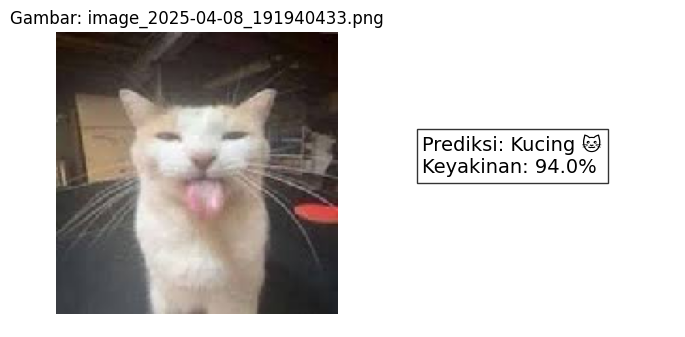


Hasil: Kucing 🐱 (94.0% yakin)


In [28]:
# Upload gambar untuk di prediksi
uploaded = files.upload()

for filename in uploaded.keys():
    # Memproses gambar
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(150, 150))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    confidence = model.predict(img_array)[0][0]
    predicted_class = "Anjing 🐶" if confidence > 0.5 else "Kucing 🐱"
    confidence_pct = max(confidence, 1-confidence) * 100

    # Menampilkan hasil
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Gambar: {filename}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.text(0.1, 0.5,
             f"Prediksi: {predicted_class}\nKeyakinan: {confidence_pct:.1f}%",
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))
    plt.axis('off')

    plt.show()

    print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% yakin)")

In [29]:
!pip freeze > requirements.txt